<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/image_data_augmentation_and_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Data Augmentation and Synthetic Data

One of the best ways to improve performance of any model is to give it
as much training data as we can, while avoiding overfitting.

When we’re working with images, we can easily create lots of new data
by simply manipulating the images we already have, creating a wide
variety of variations on the original. We could move each image left,
right, up, or down, make it a little smaller or larger, rotate it clockwise
or counter-clockwise by some amount, or perhaps flip it horizontally
or vertically.

<img src='https://github.com/rahiakela/img-repo/blob/master/augmenting-image.PNG?raw=1' width='800'/>

The process of enlarging a dataset by creating variations is called data
amplification, or data augmentation.

When we’re working specifically with images, Keras provides
a built-in object to perform data augmentation. It’s called the
ImageDataGenerator, and it performs all of the modifications we just
mentioned, and a few others besides.

A generator, in Python, can be thought of as a function that runs an internal loop, typically carrying out calculations and producing data. When that loop
reaches a yield statement, the generator returns control to the routine
that called it, with the argument to yield set to its value, just like a return statement. But if we call that function again, the loop picks up
where it most recently stopped, and continues as though it had never
been interrupted.

The ImageDataGenerator is set up this way because we can configure
it to produce large numbers of variations on each of our input
images. This can take a lot of time and a lot of computer memory. So
rather than compute all the variations ahead of time and hold on to
them until they’re needed, the generator creates batches of images on
demand. Each time we call the generator, it will produce and return
another batch of images.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


In [0]:
random_seed = 42
np.random.seed(random_seed)

image_size = 64
image_width = image_height = image_size
number_of_classes = 5

In [3]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='test')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

## Data generation from MNIST

The overall process of setting up and using the generator takes
only two steps. 

* First, we create our ImageDataGenerator with
the options we want. 
* Second, we train our model. But instead of
using fit() to start training, we use fit_generator(). 

These both take the same arguments with one exception: The first argument to
fit_generator() is a function that returns batches of samples.

The usual function that we provide to fit_generator() is a function
called flow(), which is automatically created for us as part of our
ImageDataGenerator object.

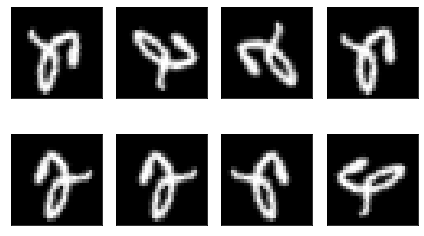

In [5]:
# Use just one image
X_train = np.reshape(8 * [X_train[5]], (8, 28, 28, 1))
y_train = 8 * [y_train[5]]

image_generator = ImageDataGenerator(rotation_range=100, horizontal_flip=True)
image_generator.fit(X_train)

for X_batch, y_batch in image_generator.flow(X_train, y_train, batch_size=8, seed=42):
  for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_batch[i].reshape(28, 28), cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
  break

plt.tight_layout()
plt.show()

Together, fit_generator() and flow() manage the production of
batches of images, and presenting them to our model for training.

In [0]:
def make_cnn_model():
  model = Sequential()
  model.add(Conv2D(16, (5, 5), activation='relu', padding='same', kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [0]:
# fit our model using images produced by the image generator
# ref: https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/
cnn_model = make_cnn_model()
cnn_history = cnn_model.fit_generator(
    image_generator.flow(X_train, y_train, batch_size=256), 
    validation_data=(X_test, y_test), epochs=100, steps_per_epoch=len(X_train) // 256)

  ...
    to  
  ['...']
Train for 1 steps, validate on 10000 samples
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.7102 - accuracy: 0.0000e+00 - val_loss: 2.3616 - val_accuracy: 0.1032
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 1.5499 - accuracy: 1.0000 - val_loss: 2.6908 - val_accuracy: 0.1032
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6567 - accuracy: 1.0000 - val_loss: 3.8122 - val_accuracy: 0.1032
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.1339 - accuracy: 1.0000 - val_loss: 5.7150 - val_accuracy: 0.1032
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 7.8873 - val_accuracy: 0.1032
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 10.0885 - val_accuracy: 0.1032
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 1.1183e-04 - accuracy: 1.00

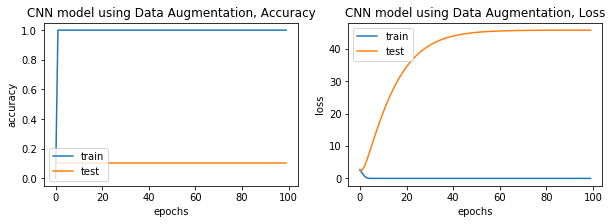

In [0]:
plot_accuracy_and_loss(cnn_history, 'CNN model using Data Augmentation')

## Synthetic Data

A great way to create an environment where we control everything is
to train on our own data, which we generate on demand. Then we can
make the data we want, rather than search for something out there
that comes close.

We use the phrase synthetic data to describe data that we create ourselves,
usually on the fly with an algorithm.

The great thing about generating synthetic data is that we can make as
much of it as we want or need, and then train with it as usual.

It’s conceptually easy to do this. We just hook our data-generating program
into a variation of the ImageDataGenerator object.

The trick here is to modify the flow() routine inside our
ImageDataGenerator object. Normally, flow() pulls the next sample
out of the training set, and then applies our requested transformations
to it. We can modify that step so that instead of pulling a sample from
the training set, it calls a routine to create a brand-new new sample
and its label. Then that new sample gets transformed and returned, as
usual.

To demonstrate the idea, we’ve written a little routine that draws an
image in a 64 by 64 square. There are five types of images: a Z shape, a
plus sign, three vertical lines, a squared U, and a circle. Each time we
draw one of these shapes we wiggle the points around a little, so that
no two shapes are the same. The function returns the image it drew
and the label. The label is a number from 0 to 4 that identifies which
type of shape is in the image.

In [0]:
from numpy.random import randint, uniform
from keras.preprocessing.image import img_to_array
import cv2
import math

def makeSyntheticImage():
  # Create a black image
  half_size = int(image_size/2.0)
  img = np.zeros((image_size, image_size, 3), np.uint8)
  img_type = randint(0, number_of_classes)
  if img_type == 0: # circle
      cx = 32
      cy = 32
      r = half_size * uniform(.6, .9)
      cv2.circle(img, (wub(cx), wub(cy)), int(wub(r)), (255,255,255), 2)
  elif img_type == 1: # plus sign
      cv2.line(img, (wub(32), wub(10)),(wub(32), wub(54)), (255,255,255), 2)
      cv2.line(img, (wub(10), wub(32)),(wub(60), wub(32)), (255,255,255), 2)
  elif img_type == 2: # three  lines
      cv2.line(img,(wub(15), wub(10)), (wub(15), wub(54)), (255,255,255), 2)
      cv2.line(img,(wub(33), wub(10)), (wub(33), wub(54)), (255,255,255), 2)
      cv2.line(img,(wub(51), wub(10)), (wub(51), wub(54)), (255,255,255), 2)
  elif img_type == 3: # Z
      x1 = wub(54)
      y1 = wub(10)
      x2 = wub(10)
      y2 = wub(54)
      cv2.line(img, (wub(10), wub(10)), (x1,y1), (255,255,255), 2)
      cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
      cv2.line(img, (x2, y2), (wub(54), wub(54)), (255, 255, 255), 2)
  else: # U
      x1 = wub(10)
      y1 = wub(54)
      x2 = wub(54)
      y2 = wub(54)
      cv2.line(img, (wub(10), wub(10)), (x1,y1), (255,255,255), 2)
      cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
      cv2.line(img, (x2, y2), (wub(54), wub(10)), (255, 255, 255), 2)
  sample = img_to_array(img)
  sample = sample[:,:,0]/255.0
  sample = sample.reshape((sample.shape[0], sample.shape[1], 1))

  return (sample, img_type)

# create a little wubble (a uniform, or symmetrical, wobble)
def wub(p):
  range = 5
  return randint(p - range, p + range + 1)

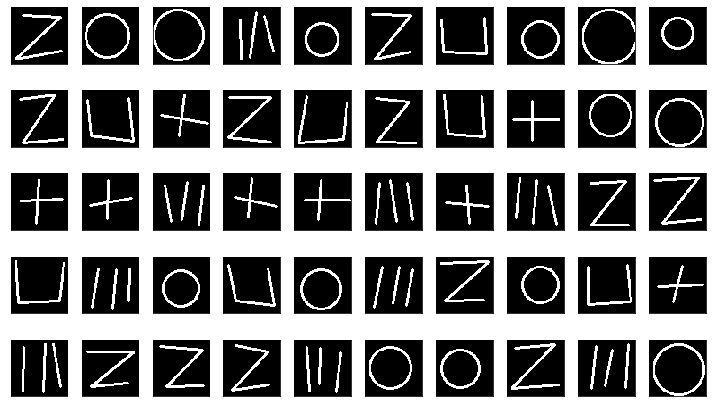

In [25]:
# Show a grid of random synthetic images
np.random.seed(5)
num_rows = 5
num_columns = 10
plt.figure(figsize=(10,6))
for y in range(num_rows):
    for x in range(num_columns):
        index = (y*num_columns)+x
        plt.subplot(num_rows, num_columns, 1 + index)
        (img, label) = makeSyntheticImage()
        img = img.reshape(64, 64)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.xticks([],[])
        plt.yticks([],[])
plt.tight_layout()
plt.show()

## Build the ImageDataGenerator

Reference: https://www.kaggle.com/hexietufts/easy-to-use-keras-imagedatagenerator

In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, Iterator, NumpyArrayIterator

class SyntheticImageGenerator(ImageDataGenerator):

  def __init__(self, batch_size=1, shuffle=True, seed=None):
    X = np.zeros(shape=(1, 64, 64, 1))   # 1 instance, of shape (64,64) with 1 channel
    self.batch_size = batch_size 
    super(SyntheticImageGenerator, self).__init__(X.shape[0], batch_size, shuffle, seed)

  # this is why we're here - override the old flow()
  def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg'):
    return SyntheticIterator(X, y, self, batch_size=batch_size, shuffle=shuffle, seed=seed,
                             save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)
    
class SyntheticIterator(NumpyArrayIterator):

  def __init__(self, X, y, image_data_generator, batch_size=32, shuffle=False, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg'):
    if len(X) != len(y):
        raise Exception('X (images tensor) and y (labels) '
                        'should have the same length. '
                        'Found: X.shape = %s, y.shape = %s' % (np.asarray(X).shape, np.asarray(y).shape))
    self.X = X
    self.y = y
    self.image_data_generator = image_data_generator
    self.save_to_dir = save_to_dir
    self.save_prefix = save_prefix
    self.save_format = save_format
    super(NumpyArrayIterator, self).__init__(X.shape[0], batch_size, shuffle, seed)

  def next(self):
    # for python 2.x.
    # Keeps under lock only the mechanism which advances
    # the indexing of each batch
    # see http://anandology.com/blog/using-iterators-and-generators/
    with self.lock:
        index_array, current_index, current_batch_size = next(self.index_generator)
    # The transformation of images is not under thread lock so it can be done in parallel
    batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
    batch_y = np.zeros(tuple([current_batch_size] + list(self.y.shape)[1:]))
    for i, j in enumerate(index_array):
        (sample, label) = self._drawImage()
        batch_x[i] = sample
        batch_y[i] = np_utils.to_categorical([label], number_of_classes)

    if self.save_to_dir:
        for i in range(current_batch_size):
            img = array_to_img(batch_x[i], scale=True)
            fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                              index=current_index + i,
                                                              hash=np.random.randint(1e4),
                                                              format=self.save_format)
            img.save(os.path.join(self.save_to_dir, fname))
    return batch_x, batch_y

  def _drawImage(self):
    return makeSyntheticImage()

In [0]:
# Make a dataset so that we have something to test again when fitting,
# and come up with a validation accuracy and loss.
def make_dataset(number_of_images):
  X = np.zeros(shape=(number_of_images, image_height, image_width, 1))
  y = np.zeros(shape=(number_of_images), dtype='uint8')
  for i in range(number_of_images):
    (sample, label) = makeSyntheticImage()
    X[i] = sample
    y[i] = label
  return (X, y)

## Synthetic CNN model using Image Data Generator

We used a version of ImageDataGenerator modified as above to train
the simple convnet.

<img src='https://github.com/rahiakela/img-repo/blob/master/data-gen-cnn-model.PNG?raw=1' width='800'/>

A simple convnet for classifying our synthetic data.

In [0]:
def make_synthetic_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 1)))
  model.add(Flatten())
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [29]:
from keras.utils import np_utils
np.random.seed(random_seed)

batch_size=256

# make validation data
(X_test, y_test) = make_dataset(10*batch_size)
y_test = np_utils.to_categorical(y_test, number_of_classes)

datagen = SyntheticImageGenerator()
dummy_X_train = np.zeros(shape=(batch_size, image_height, image_width, 1))
dummy_y_train = np.zeros(shape=(batch_size, number_of_classes))

synthetic_cnn_model = make_synthetic_model()
synthetic_cnn_history = synthetic_cnn_model.fit_generator(datagen.flow(dummy_X_train, dummy_y_train, batch_size=256, save_to_dir='.'),
                                          validation_data=(X_test, y_test), epochs=100, steps_per_epoch=len(dummy_X_train) // 256, verbose=1)

TypeError: ignored

In [0]:
plot_accuracy_and_loss(synthetic_cnn_history, 'Synthetic CNN')

Despite being about as tiny as a classifier convnet can be, the network
manages impressive accuracy on the test data, without obvious
overfitting.